---
# **Calculating Video Metrics using FFMPEG w libVMAF**

---
>Google Colab
1. Takes a MP4 video file as input (Video)
2. Adds Noise to the video (Video+Noise)
3. Calculates Video quality metrics on Video+Noise file, using Video file as the reference
4. Plots the video quality metrics for each frame
5. Plays back videos side by side

---
>**Input:**
* MP4 video (<30MB -- larger will cause runtime to disconnect)

>**Output:**
* Side by side of Video and Video+Noise
* Mean PSNR/SSIM/VMAF
* Plots of Metrics for each frame

---

Download and Uncompress FFMPEG w LibVMAF
> Note: FFMPEG normal build does not include VMAF

In [1]:
#install ffmpeg
#!pip install ffmpeg

#create directory
!mkdir ffmpeg-git-amd64-static

#install ffmpeg with libvmaf (prebuilt)
!wget https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
!tar -xvf "ffmpeg-git-amd64-static.tar.xz" --directory "ffmpeg-git-amd64-static" --strip-components=1

--2023-11-20 22:23:30--  https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
Resolving johnvansickle.com (johnvansickle.com)... 107.180.57.212
Connecting to johnvansickle.com (johnvansickle.com)|107.180.57.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41364204 (39M) [application/x-xz]
Saving to: ‘ffmpeg-git-amd64-static.tar.xz’

ffmpeg-git-amd64-st 100%[===================>]  39.45M  94.9MB/s    in 0.4s    

2023-11-20 22:23:31 (94.9 MB/s) - ‘ffmpeg-git-amd64-static.tar.xz’ saved [41364204/41364204]

ffmpeg-git-20231117-amd64-static/GPLv3.txt
ffmpeg-git-20231117-amd64-static/manpages/
ffmpeg-git-20231117-amd64-static/manpages/ffmpeg-all.txt
ffmpeg-git-20231117-amd64-static/manpages/ffmpeg-scaler.txt
ffmpeg-git-20231117-amd64-static/manpages/ffmpeg-resampler.txt
ffmpeg-git-20231117-amd64-static/manpages/ffmpeg-filters.txt
ffmpeg-git-20231117-amd64-static/manpages/ffprobe.txt
ffmpeg-git-20231117-amd64-static/manpages/ffmpeg-devices.txt
f

Prompts user to choose video file to be used as input

> Make sure video file is small. Video files larger that 30MB may take longer to process or disconnect the runtime.


In [2]:
#import video file into local directory /content/
#Example input video: https://drive.google.com/file/d/1-z98fyhQMMNgVURPtuJj2aBN-rRnHxEV/view?usp=drive_link
from google.colab import files

video = files.upload()

input_file="input.mp4"

Saving input.mp4 to input.mp4


Lists parameters for each frame in video
> (To be used in future)



In [3]:
#lists parameters of each frame in video
#output=!ffmpeg-git-20231006-amd64-static/ffprobe -hide_banner -v error -select_streams v:0 -show_frames input.mp4
#print(output)

Prompts user for type of deterioration to add to input video
Options are:
>1. Spatial & Temporal - Adds pixel level noise to the whole image (e.g. grainy)
>2. Compression - Adds compression artifacts (e.g. loss of sharpness)
>3. Missing Frames - Removes frames (e.g. image loss)
>4. Frozen Frames - Freezes frames (e.g. repeated frame, image loss)
>5. All of the Above - Combines all of the above

> Output is saved as "input_with_noise.mp4"


In [9]:
#Ask User for what type of deterioration to apply to the original video
UserInput = int(input("1. Spatial & Temporal Noise\n2. Compression\n3. Missing Frames\n4. Frozen Frames\nSelect 1,2,3 or 4:\n"))

noise=40 #level of spatial and temporal noise
crf=30 #constant rate factor - level of compression
missing_frame=30 #insert 1 missing frame every 30 frames
freeze_frame=35 #insert 1 frozen frame every 35 frames

#Spatial & Temporal Noise -- Insert Noise onto Video
#Note: increasing noise level to 80, generates a 30MB file input_with_noise.mp4 and causes runtime to disconnect in later code
if UserInput == 1:
  !ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -filter:v "noise=alls="{noise}":allf=t+u" -y input_with_noise.mp4

#Compress Video
#CRF is constant rate factor. Higher CRF (30) produces smaller video file size, with lower quality. Lower CRF produces larger file size, but higher quality video.
#CRF=20 is reommended for most uses.
elif UserInput ==2:
    !ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -vcodec libx264 -pix_fmt yuv420p -crf {crf} -y input_with_noise.mp4 -loglevel error

#Missing Frames
#inserts missing frames into video
elif UserInput ==3:
    !ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -vf "[0:v]drawbox=x=0:y=0:w=iw:h=ih:t='10':thickness=fill:color=black:enable='not(mod(n\,30))'" -an -y input_with_noise.mp4
    #!ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -filter:v "select=not(mod(n\,5)),drawbox=x=0:y=0:w=iw:h=ih:color=black" -y input_with_noise_%03d.jpg

#Frozen Frames
#inserts frozen frames into video
elif UserInput ==4:
    #!ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -vf "[0:v]drawbox=x=0:y=0:w=iw:h=ih:t='10':thickness=fill:color=black:enable='not(mod(n\,30))'" -an -y input_with_noise1.mp4
    !ffmpeg-git-amd64-static/ffmpeg -i input.mp4 -filter_complex "[0:v]select='mod(n,30)'[v];[v][0:v]overlay=x=0:y=0:enable='(mod(n,30))'" -an -y input_with_noise.mp4

else:
  print("Not a valid selection.")

1. Spatial & Temporal Noise
2. Compression
3. Missing Frames
4. Frozen Frames
Select 1,2,3 or 4:
4
ffmpeg version N-67789-g08e97dae20-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --

Calculates Video Quality Metrics (PSNR, SSIM and VMAF) on "Input_with_noise.mp4"
> Reference video is "input.mp4"
> Logs are stored in JSON format in "metric.log"



In [10]:
# Calculate per frame PSNR, SSIM, VMAF. Caution: this may take a while.
metric_log = 'metric.log'
!if test -f $metric.log; then rm {metric_log}
!ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input_with_noise.mp4 -i input.mp4 -filter_complex libvmaf='feature=name=psnr|name=float_ssim:log_path={metric_log}:log_fmt=json' -f null -

/bin/bash: -c: line 2: syntax error: unexpected end of file
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'input_with_noise.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    title           : 1064319234
    encoder         : Lavf60.17.100
    comment         : This video is subject to copyright.
    copyright       : This video is subject to copyright.
  Duration: 00:00:12.84, start: 0.000000, bitrate: 1035 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 640x360 [SAR 1:1 DAR 16:9], 1032 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc60.33.100 libx264
Input #1, mov,mp4,m4a,3gp,3g2,mj2, from 'input.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isom
    creation_time   : 2018-11-12T09:41:40.000000Z
    comment         : This video is

Each Video Metric (PSNR, SSIM, VMAF) is plotted across all frames
> Quick way of identifying which frame(s) had negative impact on score
*   X axis = Frames in video
*   Y axis = Metric Score
* Example:

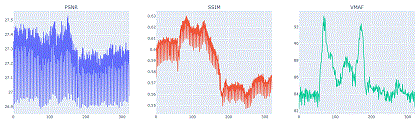


In [12]:
# Plot the per frame PSNR/SSIM/VMAF.
#From: https://jina-liu.medium.com/video-stream-analysis-in-jupyter-notebook-4142e10fc07c

import json
with open(metric_log) as f:
  data = json.load(f)

metric_dict = {
    'index': list(range(len(data['frames']))),
    'psnr': [f['metrics']['psnr_y'] for f in data['frames']],
    'ssim': [f['metrics']['float_ssim'] for f in data['frames']],
    'vmaf': [f['metrics']['vmaf'] for f in data['frames']]
}

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3, subplot_titles=['PSNR', 'SSIM', 'VMAF'])

fig.add_trace(
    go.Scatter(x=metric_dict['index'], y=metric_dict['psnr']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=metric_dict['index'], y=metric_dict['ssim']),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=metric_dict['index'], y=metric_dict['vmaf']),
    row=1, col=3
)

fig.update_layout(showlegend=False)
fig.show()

Prints out the Mean of each metric (PSNR, SSIM, VMAF) for all frames
> This comes from last entries of "metric.log"
* PSNR scale is 0 (worst) to 60 (best)
* SSIM scale is -1 (worst), 0 (no similarity), 1 (best)
* VMAF scale is 0 (worst) to 100 (best)





In [13]:
#print out the Mean of the Metrics (PSNR, SSIM, VMAF)
import json
with open(metric_log) as f:
  data = json.load(f)
psnr_avg=data['pooled_metrics']['psnr_y']['mean']
ssim_avg=data['pooled_metrics']['float_ssim']['mean']
vmaf_avg=data['pooled_metrics']['vmaf']['mean']
print("PSNR Mean: ", psnr_avg)
print("SSIM Mean: ", ssim_avg)
print("VMAF Mean: ", vmaf_avg)

PSNR Mean:  37.895325
SSIM Mean:  0.968132
VMAF Mean:  94.920563


Function to play back 2 videos side-by-side and label them

In [14]:
#function to play back video in browser
from IPython.display import HTML
from base64 import b64encode


def play_video2(filename_1, label_1, filename_2, label_2, height=512, width=512):
    mp4_1 = open(filename_1, 'rb').read()
    data_url_1 = "data:video/mp4;base64," + b64encode(mp4_1).decode()
    mp4_2 = open(filename_2, 'rb').read()
    data_url_2 = "data:video/mp4;base64," + b64encode(mp4_2).decode()
    return HTML(f"""<table>
      <tr>
        <td><h3><center>{label_1}</center><h3></td>
        <td><h3><center>{label_2}</center></h3></td>
      </tr>
      <tr>
        <td><video width={width} height={height} controls autoplay><source src={data_url_1} type="video/mp4"></video></td>
        <td><video width={width} height={height} controls autoplay><source src={data_url_2} type="video/mp4"></video></td>
      </tr>
    </table>""")

Plays back original video ("input.mp4") and ("input_with_noise.mp4") side-by-side
>Mean video metrics are shown for "input_with_noise.mp4"

In [15]:
#playback input and input_with_noise
label_1="Original Video"
label_2="Video + Noise <br>PSNR:"+str(psnr_avg)+"<br>SSIM: "+str(ssim_avg)+"<br>VMAF: "+str(vmaf_avg)
play_video2('input.mp4', label_1, 'input_with_noise.mp4', label_2)

Output hidden; open in https://colab.research.google.com to view.

---
That's it for now...

---

Future Ideas:
* Automate generation of noise at different levels and plot the Metrics vs Noise Level
* Aside from Spatial and Temporal Noise, introduce other artifacts
* Add more video content options

